# HOST

**Author:** _Matteo Bagagli_ - **Date:** _10/2021_ - **Version:** _2.2.1_

-------------------------------------------------------------------------------------------------------------------

The **HOST** acronym stands for **H**igh-**O**rder-**ST**atistics seismic pickers.
This algorithm took inspiration from the one described in [_Baillard et al. 2014_](10.1785/0120120347). 
The idea behing this package is to provide user-friendly classes for seismic phase picking with _skewness_ and _kurtosis_ carachteristic-functions. I

Originally applied to seismograms by [_Saragiotis et al._](10.1109/TGRS.2002.800438), the HOS-CF are able to detect energic transient when the statistical properties of a seismogram (or time series) change abruptly. These CF are calculated on moving window with fixed window.

Measurements of statistical properties in a moving window are suitable for frequency-specific (or expected) transient. For this reason, the picker support a multi-window analysis, in order to collecto more information or even increase the quality of about 

Both _skewness_ and _kurtosis_ are calculated with C-routine under the hood, making this package fast and suitable also for realtime picking porpouses.

For the installation please refer to the `README.md` file in the project-home (for both standard and developer installation)


## Skewness CF

The skewness is defined as follows, using the 3rd central-moment third central moment of a continous distribution. 

$$
S=\frac{E\left[(X-E[X]]^{3}\right.}{E[X-E[X]]^{3 / 2}}=\frac{m_{3}}{m_{2}^{3 / 2}}
$$

The skewness provides information about positive or negative deviations of the distribution density function from the expectation value.

## Kurtosis CF

The kurtosis is defined as follows, using the 4th central-moment third central moment of a continous distribution. 

$$
K=\frac{E\left[(X-E[X]]^{4}\right.}{E[X-E[X]]^{4 / 2}}=\frac{m_{4}}{m_{2}^{2}}
$$

The kurtosis provides information about only positive deviations of the distribution density function from the expectation value.

# Let's go (super-quick)!

First, let's import the `ObsPy` library and the package main class `Host`. Once loaded the waveform, we do a first standard pre-processing of the data ...

In [1]:
import sys
import logging
from obspy import read, UTCDateTime
from host.picker import Host
from host.plotting import plot_HOST
# ----------------------------------------
%matplotlib inline 
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# ----------------------------------------

def miniproc(st):
    prs = st.copy()
    prs.detrend('demean')
    prs.detrend('simple')
    prs.taper(max_percentage=0.05, type='cosine')
    prs.filter("bandpass",
               freqmin=1,
               freqmax=30,
               corners=2,
               zerophase=True)
    return prs

straw = read("../tests_data/obspy_read.mseed")
stproc = miniproc(straw)
trproc = stproc.select(channel="*Z")[0]
tr = trproc.copy()

As the trace contains the entire waveforms, we want to get close to the real onset ...

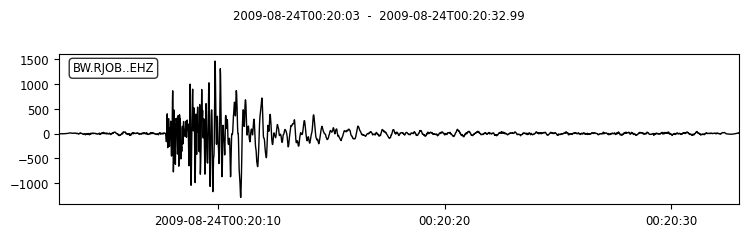

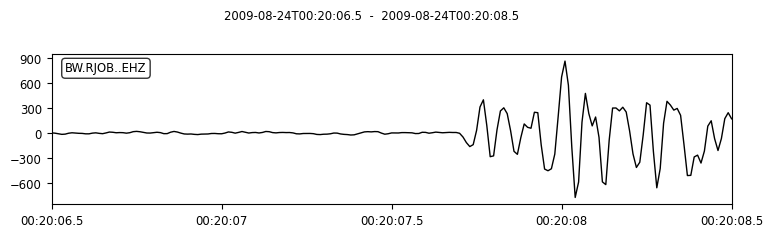

In [2]:
# Entire wave
tr.plot()

# Trimming
tr.trim(UTCDateTime("2009-08-24T00:20:06.500000"),
        UTCDateTime("2009-08-24T00:20:08.500000"))

tr.plot();


Now we want to initialize the main picker object, by providing the processed trace and the time-window (in seconds) for the CF calculation, and the `hos_method` (either `'skew'` or `'kurt'`) ...

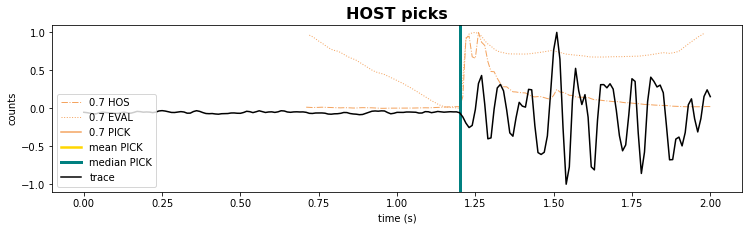

In [3]:
HP = Host(tr, 0.7, hos_method='kurtosis')  # also 'kurt' and 'k' works ... 
HP.work(debug_plot=True)

_NB: Please not that the plots values are normalized for the sake of clarity_

Now here's the debug plot of the HOST object, where we can see the simple kurtosis and, most important the _evaluation function_. This function is responsible for the pick definition. In this case, there's the default AIC function, calculated over the CF (in this case kurtosis). The pick is declared were the minimum of the AIC function is reached. 


Let's explain the legend entries now:
- **X.X HOS** represents the trace HOS-CF for the given time-window. In case of additional transformation, those are accounted as well, and the final plot will be the resulting one
- **X.X EVAL** represents the evaluation function (i.e. AIC or gaussian) for the given HOS-CF
- **X.X PICK** represents the pick obtained by the EVAL function.
- **mean pick** in case of multi-window approach, it represent the `mean-value` among them, otherwise it equals the single window one
- **median pick** in case of multi-window approach, it represent the `median-value` among them, otherwise it equals the single window one
- **trace** is just the input-trace

If we would like to use skewness in this case , we could use the `set_host_method` class-method, and see the outcome.

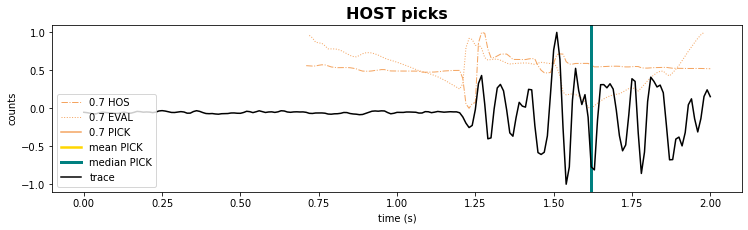

In [4]:
HP.set_hos_method('skewness')  # also 'skew' and 's' works ... 
HP.work(debug_plot=True)

With the different shape of _skewness_ in respect _kurtosis_, though, the AIC function reach its minimum on a later transient. There is actually a strong minimum or the AIC at the right phase-onset, though is just a relative- and not the absolute-maxima.

For this reason, we could try to work on the HOS-CF by directly selecting the absolute function's minima. In order to do so, we need to use first the `set_detection_method` to `'minima'`.

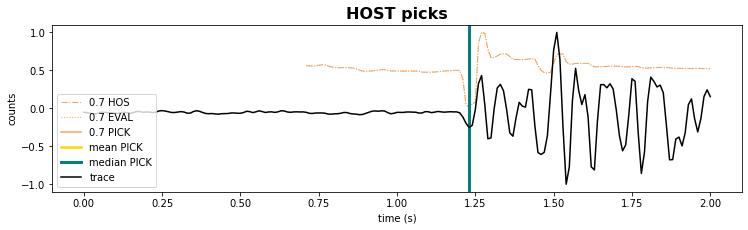

In [5]:
# In these case (minima case-evaluation), the HOS-EVAL counts as the HOS itself
HP.set_detection_method('min') 
HP.work(debug_plot=True)

From this plot, still, we see the unprecise detection of the first arrival. This because the skewness is recalling the shape of the onset (at the arrival stage) and therefore reaching its maxima _after_ the onset sample.

But what if we try to **shrink** the analysis-window and repeat the `AIC` evaluation over the `skewness` HOS-CF? Let's see ...

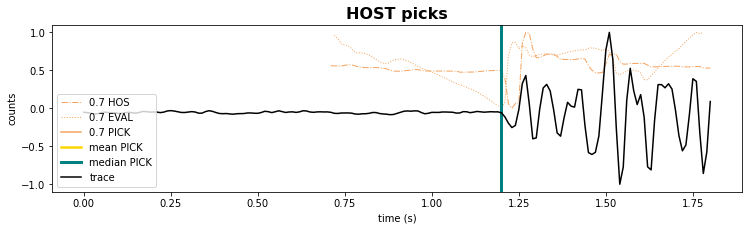

In [6]:
tr.trim(tr.stats.starttime, tr.stats.starttime + 1.8)
HP = Host(tr, 0.7, hos_method='s') 
HP.set_detection_method('AIC') 
HP.work(debug_plot=True)

Eureka! Now the AIC's minima falls right at the first-onset. Such experiment is a confirmation of how the analysis window and the amount of data processed is important for this functions, and that these parameters must be treated as important as the others!

### References
- Baillard, C., Crawford, W.C., Ballu, V., Hibert, C. and Mangeney, A., 2014. An automatic kurtosis‐based P‐and S‐phase picker designed for local seismic networks. Bulletin of the Seismological Society of America, 104(1), pp.394-409.
- Saragiotis, C.D., Hadjileontiadis, L.J. & Panas, S.M., 2002. PAI-S/K: a robust automatic seismic P phase arrival identification scheme, IEEE Trans. Geosci. Remote Sens. 40, 1395–1404.